# **TAT - Final Code Module**
---
## **SubModules:**

*   #### **Module1 -** **Signature Detection & Extraction.**
    * **Functions:** **`def pdfjpg(path1, path2)`, `sigExtract(inputPath, outputPath)` & `def extractor(inputPath, outputPath)` (Not in use due to questionable accuracy)** 
---

*   #### **Module2 -** **Signature Structural Similarity Comparision.**
    * **Functions:** **`def match(path1, path2, countour = False)`**
---
*   #### **Module3 -** **Signature Authentication Using Siamese Neural Network.**
    * **Functions:** **`def invert_image_path(path)`, `def generate_batch(all_pairs,all_labels,batch_size)`, `def euclidean_distance(vects)`, `def eucl_dist_output_shape(shapes)`, `def contrastive_loss(y_true, y_pred)`, `def predict_score()`, `def predict_score_two(test_gen)` & `def show_result_two(path1,path2,define_label=0)`**
---
*   #### **Module4 -** **Extracting Text From The Document.**
    * **Functions:** **`def text_extract(path)`, `def remove(text)`**
---
*   #### **Module5 -** **Text Similarity Analysis (Cosine Similarity).**
    * **Functions:** **`def process(file)`, `def cos_sim(a,b)`, `def getSimilarity(dict1,dict2)`**
---
*   #### **Module6 -** **Tracking Text Modifications Through Text Parsing.**
    * **Functions:** **`def read_text_byphase(f)`, `def findit(data,keywords)`, `def get_difference_result(path_first,path_second,keywords)`**
---

In [ ]:
# signature-detect
# !apt-get -qq install libmagickwand-dev
# !pip -q install signature-detect 
!pip install pdf2image
!apt-get install poppler-utils
import numpy as np
from scipy import ndimage
from skimage.transform import resize
import matplotlib.pyplot as plt

# from signature_detect.loader import Loader
# from signature_detect.extractor import Extractor
# from signature_detect.cropper import Cropper
# from signature_detect.judger import Judger
from pdf2image import convert_from_path

# SSIM
import cv2
from skimage.metrics import structural_similarity as ssim
import imutils
from google.colab.patches import cv2_imshow


# SIAMESE NEURAL NETWORK
import pandas as pd
import sys
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from google.colab.patches import cv2_imshow
import time
import itertools
import random
!pip install --ignore-installed Pillow==9.0.0
from PIL import Image
from PIL.ImageOps import invert
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import tensorflow_hub as hub
from sklearn.utils import shuffle
from keras import models
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.layers import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# NLP
import os
import re
import pandas as pd
import tensorflow as tf
import numpy as np
!pip install PyPDF2
import PyPDF2
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM
from keras.callbacks import LambdaCallback
from collections import Counter
tok = Tokenizer()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import nltk
import warnings
warnings.filterwarnings("ignore")

## **Functions *(Signature Authentication)***
The code cell below contains all the functions that correspond to Signature detection, extraction, comparision and authentication.

In [ ]:
img_h, img_w = 155, 220
input_shape= (img_h, img_w, 1)

def invert_image_path(path):
    image_file = Image.open(path)  # open colour image
    image_file = image_file.convert('L').resize([220, 155])
    # image_file = image_file.convert('L').resize([224, 224])
    image_file = invert(image_file)
    image_array = np.array(image_file,dtype = np.float64)
    image_array[image_array >= 50] = 255
    image_array[image_array < 50] = 0
    return image_array

def generate_batch(all_pairs,all_labels, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:   
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = invert_image_path(pair[0])
            img2 = invert_image_path(pair[1])
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims = True))
  
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))
  
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax2.set_title('Genuine')
    if test_label == 1:
        ax1.set_title('Genuine')
    else:
        ax1.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

def predict_score_two(test_gen):
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('image1')
    ax2.set_title('image2')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = new_model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    # if diff > 0.5474644088745119:
    if diff > 0.2:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

def show_result_two(path1,path2,define_label=0):
    label_test=[define_label]
    left=list()
    right=list()
    left.append(path1)
    right.append(path2)
    pairs = np.stack([left, right], axis=1)
    test_ge = generate_batch(pairs,label_test, 1)
    return predict_score_two(test_ge)

def sigExtract(inputPath, outputPath):
  # Load image and HSV color threshold
  image = cv2.imread(inputPath)
  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  lower = np.array([10, 10, 0])
  upper = np.array([145, 500, 255])
  mask = cv2.inRange(hsv, lower, upper)
  result = cv2.bitwise_and(image, image, mask=mask)
  result[mask==0] = (255,255,255)

  # Find contours on extracted mask, combine boxes, and extract ROI
  cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  cnts = np.concatenate(cnts)
  x,y,w,h = cv2.boundingRect(cnts)
  cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
  # print(x, y, w, h)
  ROI = image[y:y+h, x:x+w]
  cv2.imwrite(outputPath, ROI)

  # cv2_imshow(result)
  # cv2_imshow(mask)
  # cv2_imshow(image)
  cv2_imshow(ROI)
  # cv2.waitKey()


def match(path1, path2, countour = False):
    # read the images
    img1 = cv2.imread(path1)
    img2 = cv2.imread(path2)
    # turn images to grayscale
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    # resize images for comparison
    img1 = cv2.resize(img1, (300, 300))
    img2 = cv2.resize(img2, (300, 300)) 

    (score, diff) = ssim(img1, img2, full=True)
    diff = (diff * 255).astype("uint8")

    if countour == True:
      thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
      cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      cnts = imutils.grab_contours(cnts)
      
      for c in cnts:
        # compute the bounding box of the contour and then draw the
        # bounding box on both input images to represent where the two
        # images differ
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(img1, (x, y), (x + w, y + h), (0, 0, 255), 2)
        cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 0, 255), 2)
        
      # show the output images
      # cv2_imshow(img1)
      # cv2_imshow(img2)
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
      ax1.imshow(np.squeeze(img1), cmap='gray')
      ax2.imshow(np.squeeze(img2), cmap='gray')
      ax1.set_title('image1')
      ax2.set_title('image2')
      ax1.axis('off')
      ax2.axis('off')
      plt.show()

    similarity_value = "{:.2f}".format(ssim(img1, img2)*100)
    return "The two images are a " + str(float(similarity_value)) + "% match."

def show_image(img):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()


def extractor(inputPath, outputPath):  
  image = cv2.imread(inputPath)
  show_image(image)

  loader = Loader(
      low_threshold=(0, 0, 250), 
      high_threshold=(255, 255, 255))
  mask = loader.get_masks(inputPath)[0]

  extractor = Extractor(
      outlier_weight=1, 
      outlier_bias=100, 
      amplfier=100, 
      min_area_size=0.1)
  labeled_mask = extractor.extract(mask)

  cropper = Cropper(
      min_region_size=100, 
      border_ratio=0.01)
  results = cropper.run(labeled_mask)
  signature = results[0]["cropped_mask"]
  cv2.imwrite(outputPath, signature)

  image = cv2.imread(outputPath)
  show_image(image)

def pdfjpg(path1, path2):
  p1 = convert_from_path(path1)
  p2 = convert_from_path(path2)
  p1[0].save('real'+ '.jpg', 'JPEG')
  p2[0].save('forge'+ '.jpg', 'JPEG')
  # for i in range(len(p1)):
  #   p1[i].save('real'+ str(i) +'.jpg', 'JPEG')
  
  # for i in range(len(p2)):
  #   p2[i].save('forge'+ str(i) +'.jpg', 'JPEG')

## **Functions *(Document Similarity)***
The code cell below contains all the functions that correspond to Text Extraction, Bag Of Words conversion, TF-IDF Computation, Text Parsing & Comparison, and Cosine similarity. All of these individual components come together to help us analyze text similarity between two documents.

In [ ]:
#remove the punctuation
def remove(text):
    remove_chars = '[0-9’!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~]+'
    return re.sub(remove_chars, '', text)

def text_extract(path):
    pdfFileObj = open(path, 'rb')
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
    print("Number of Pages in the Document: ", pdfReader.numPages) 
    pageObj = pdfReader.getPage(0) 
    f = pageObj.extractText()

    print("Extracted Text --->")
    print(f)
    print("\n")
    pdfFileObj.close()
    f=f.lower()
    f=f.replace('\n',' ').replace('\r','')
    f=f.split()
    return f

def read_text_byphase(f):
    data=[]
    f = f.split('\n')
    for lines in f:
        sentence=[]
        lines=lines.lower()
        lines=lines.strip("\n")
        #result_list = re.split(r'[.]', lines)
        result_list = lines.split('.')
        for se in (result_list):
            #print(se)
            se=remove(se)
            if se and se != ' ':
                se=se.split()
                sentence.append(se)
        data.append(sentence)
    return data

def findit(data,keywords):
    res=[]
    for i,phase in enumerate(data):
        for j,line in enumerate(phase):
            for k,word in enumerate(line):
                if word == keywords:
                    res.append([i,j,k])
    return res

def get_difference_result(path_first,path_second,keywords):
    file1 = open(path_first, 'rb') 
    file2 = open(path_second, 'rb')
    f = PyPDF2.PdfFileReader(file1) 
    f2 = PyPDF2.PdfFileReader(file2)  
    f = f.getPage(0) 
    f2 = f2.getPage(0) 
    f = f.extractText()
    f2 = f2.extractText()
    file1.close()
    file2.close()
    data = read_text_byphase(f)
    data2= read_text_byphase(f2)
    res1= findit(data, keywords)
    res2= findit(data2, keywords)
    common_word=[]
    for m in range(len(res1)):
        word=res1[m]
        if word in res2:
            common_word.append(word)
    for n in range(len(common_word)):
        c_word=common_word[n]
        res1.remove(c_word)
        res2.remove(c_word)
    
    if res1:
        for item in res1:
            ph=item[0]+1
            line=item[1]+1
            index=item[2]+1
            print('The document deletes the old word "{}" at Phase {} , Line {} & Index {}.'.format(keywords,ph,line,index))
            # return [keywords,ph,line,index]
            # return a
    
    if res2:
        for item in res2:
            ph=item[0]+1
            line=item[1]+1
            index=item[2]+1
            print('The document adds the new word "{}" at Phase {} , Line {} & Index {}.'.format(keywords,ph,line,index))
            # return [keywords,ph,line,index]


def process(file):
    words=[words.lower() for words in file]
    porter= nltk.PorterStemmer()
    stemmed_tokens=[porter.stem(t) for t in words]
    #count words
    count=nltk.defaultdict(int)
    for word in words:
        count[word]+=1
    # print(count)
    return count;

def cos_sim(a,b):
    dot_product=np.dot(a,b)
    norm_a=np.linalg.norm(a)
    norm_b=np.linalg.norm(b)
    return dot_product/(norm_a * norm_b)

def getSimilarity(dict1,dict2):
    all_words_list=[]
    for key in dict1:
        all_words_list.append(key)
    for key in dict2:
        all_words_list.append(key)
    all_words_list_size=len(all_words_list)

    v1=np.zeros(all_words_list_size,dtype=np.int)
    v2=np.zeros(all_words_list_size,dtype=np.int)
    i=0
    for (key) in all_words_list:
        v1[i]=dict1.get(key,0)
        v2[i]=dict2.get(key,0)
        i=i+1
    return cos_sim(v1,v2)

# **Analyzing Text Similarity Between Documents (Using Natural Language Processing)**

#### **Text Extraction From Documents**

In [ ]:
path1='/content/testdocReal.pdf'
path2='/content/testdocForg.pdf'

text1=text_extract(path1)
text2=text_extract(path2)

Number of Pages in the Document:  1
Extracted Text --->
T A T
This is a test document.
Comparing document similarity.
This document was made by: Li & Chirag



Number of Pages in the Document:  1
Extracted Text --->
Trusted Authentication
This is a test file.
Comparing file similarity.
This document was made by: Li & Abhishek





#### **Analyzing Document Similarity (TF-IDF & Cosine Similarity)**

In [ ]:
dict1=process(text1)
dict2=process(text2)
print("Similarity between two text documents", getSimilarity(dict1,dict2))

Similarity between two text documents 0.8295150620062532


#### **Bag-Of-Words Conversion**

In [ ]:
counter1=Counter(text1)
dictionary1=dict(counter1)
counter2=Counter(text2)
dictionary2=dict(counter2)
print("Bag Of Words ---> Document 1")
print(dictionary1)
print("\n")
print("Bag Of Words ---> Document 2")
print(dictionary2)

Bag Of Words ---> Document 1
{'t': 2, 'a': 2, 'this': 2, 'is': 1, 'test': 1, 'document.': 1, 'comparing': 1, 'document': 2, 'similarity.': 1, 'was': 1, 'made': 1, 'by:': 1, 'li': 1, '&': 1, 'chirag': 1}


Bag Of Words ---> Document 2
{'trusted': 1, 'authentication': 1, 'this': 2, 'is': 1, 'a': 1, 'test': 1, 'file.': 1, 'comparing': 1, 'file': 1, 'similarity.': 1, 'document': 1, 'was': 1, 'made': 1, 'by:': 1, 'li': 1, '&': 1, 'abhishek': 1}


In [ ]:
differ = set(dictionary1.items()) ^ set(dictionary2.items())
differ=list(differ)

words=[]
for i in range(len(differ)):
    if differ[i][0] not in words:
        words.append(differ[i][0])

#### **Tampered Words**

In [ ]:
words

['abhishek',
 'document',
 'a',
 'chirag',
 'file',
 't',
 'file.',
 'authentication',
 'document.',
 'trusted']

#### **Tracking Text Modifications Between Documents**

In [ ]:
for w in words:
    get_difference_result(path1, path2, w)

The document adds the new word "abhishek" at Phase 4 , Line 1 & Index 7.
The document deletes the old word "document" at Phase 2 , Line 1 & Index 5.
The document deletes the old word "document" at Phase 3 , Line 1 & Index 2.
The document deletes the old word "a" at Phase 1 , Line 1 & Index 2.
The document deletes the old word "chirag" at Phase 4 , Line 1 & Index 7.
The document adds the new word "file" at Phase 2 , Line 1 & Index 5.
The document adds the new word "file" at Phase 3 , Line 1 & Index 2.
The document deletes the old word "t" at Phase 1 , Line 1 & Index 1.
The document deletes the old word "t" at Phase 1 , Line 1 & Index 3.
The document adds the new word "authentication" at Phase 1 , Line 1 & Index 2.
The document adds the new word "trusted" at Phase 1 , Line 1 & Index 1.


# **Signature Detection, Extraction, Comparision & Authentication**

#### **Converting The Document To An Image**

In [ ]:
pdfjpg("/content/testdocReal.pdf", "/content/testdocForg.pdf")

#### **Detecting & Extracting Signatures**

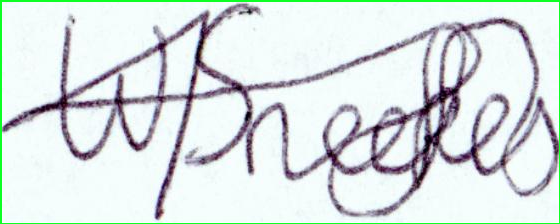

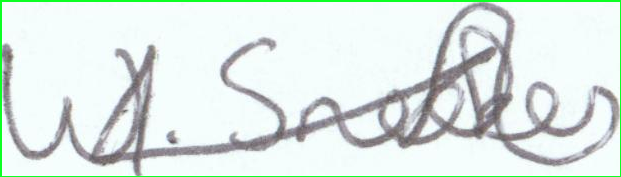

In [ ]:
sigExtract(inputPath = 'real.jpg', outputPath = 'realex.png')
sigExtract(inputPath = 'forge.jpg', outputPath = 'forgeex.png')

#### **Signature Extraction Using signature-detect module** (Currently not in use)

In [ ]:
# extractor(inputPath = 'real.jpg', outputPath = 'realex.png')
# extractor(inputPath = 'forge.jpg', outputPath = 'forgeex.png')

### **Loading The Trained, Tested & Saved Siamese Network**
#### **Importing the saved model using the .h5 file**

In [ ]:
new_model = models.load_model('new_model.h5', custom_objects={'contrastive_loss': contrastive_loss})

#### **Predicting Results Using The Siamese Network**

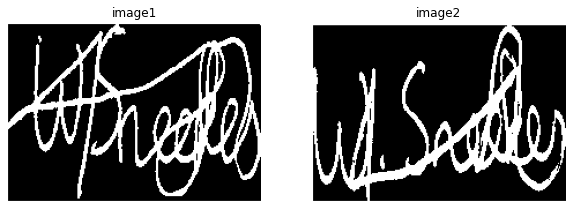

Difference Score =  0.29606396
Its a Forged Signature


In [ ]:
path1 = "/content/realex.png", path2 = "/content/forgeex.png"

show_result_two(path1,path2)

#### **Comparing The Signatures using SSIM (Structural Similarity)**

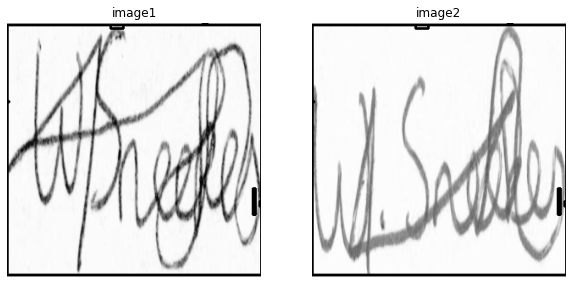

'The two images are a 42.68% match.'

In [ ]:
match(path1, path2, countour = True)

# **Final Output:**

Number of Pages in the Document:  1
Extracted Text --->
T A T
This is a test document.
Comparing document similarity.
This document was made by: Li & Chirag



Number of Pages in the Document:  1
Extracted Text --->
Trusted Authentication
This is a test file.
Comparing file similarity.
This document was made by: Li & Abhishek



Similarity between two text documents 0.8295150620062532


The words that might have been tampered with: ['file', 'trusted', 't', 'a', 'document', 'file.', 'document.', 'chirag', 'authentication', 'abhishek']


THE WORDS THAT WERE FORGED (ADDED/ERASED/MODIFIED) --->

The document adds the new word "file" at Phase 2 , Line 1 & Index 5.
The document adds the new word "file" at Phase 3 , Line 1 & Index 2.
The document adds the new word "trusted" at Phase 1 , Line 1 & Index 1.
The document deletes the old word "t" at Phase 1 , Line 1 & Index 1.
The document deletes the old word "t" at Phase 1 , Line 1 & Index 3.
The document deletes the old word "a" at Phase 1 , Li

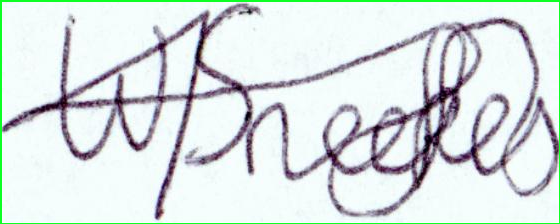

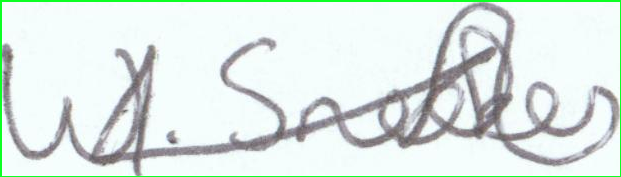



SIAMESE SIGNATURE AUTHENTICATION




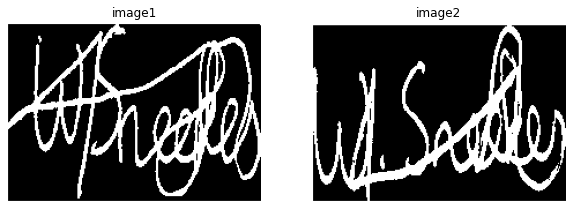

Difference Score =  0.29606396
Its a Forged Signature


ANALYZING STRUCTURAL SIMILARITY




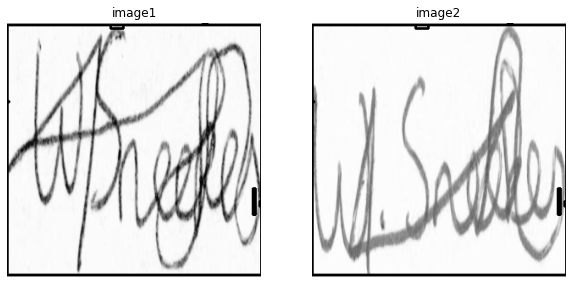

'The two images are a 42.68% match.'

In [ ]:
path1 = "/content/testdocReal.pdf"
path2 = "/content/testdocForg.pdf"
text1, text2 = text_extract(path1), text_extract(path2)
dict1, dict2 = process(text1), process(text2)
print("Similarity between two text documents", getSimilarity(dict1,dict2))

dictionary1, dictionary2 = dict(Counter(text1)), dict(Counter(text2))
differ = list(set(dictionary1.items()) ^ set(dictionary2.items()))
words=[]
for i in range(len(differ)):
    if differ[i][0] not in words:
        words.append(differ[i][0])

print('\n')
print("The words that might have been tampered with:", words)

print('\n')
print("THE WORDS THAT WERE FORGED (ADDED/ERASED/MODIFIED) --->\n")
for w in words:
    get_difference_result(path1, path2, w)

print("\n")
print("EXTRACTED SIGNATURES:")
print("\n")
pdfjpg(path1, path2)
sigExtract(inputPath = 'real.jpg', outputPath = 'realex.png')
sigExtract(inputPath = 'forge.jpg', outputPath = 'forgeex.png')

print("\n")
print("SIAMESE SIGNATURE AUTHENTICATION")
print("\n")
path1 = "/content/realex.png"
path2 = "/content/forgeex.png"
show_result_two(path1,path2)

print("\n")
print("ANALYZING STRUCTURAL SIMILARITY")
print("\n")
match(path1, path2, countour = True)